# Week 5 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [6]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

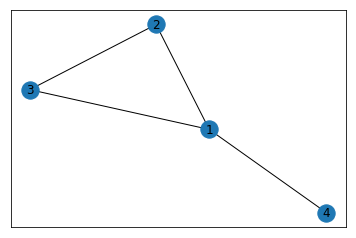

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: the Grimmer Senate press release corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4933

Total number of edges:

In [19]:
len(g.edges)

182267

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[ 4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 36.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [23]:
import sklearn.feature_extraction
# in case we get a module not found error

In [24]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [25]:
senVects_incidence.shape

(100, 4924)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [26]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [27]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 5024
Number of edges: 21256
Average degree:   8.4618


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

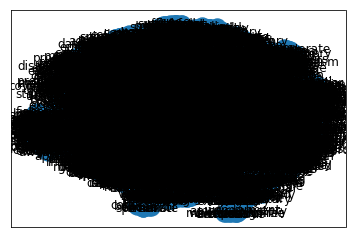

In [28]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [29]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [30]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [31]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

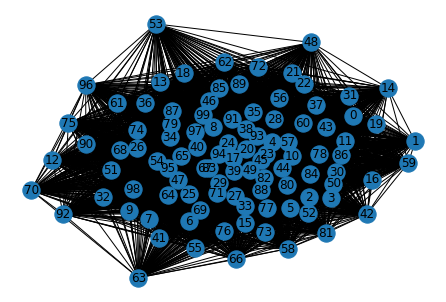

In [32]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

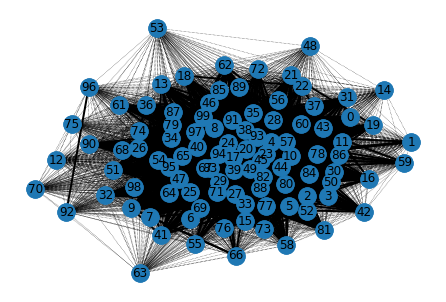

In [33]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [34]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [35]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [36]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4924
Number of edges: 2161481
Average degree: 877.9370


First, let's reduce the number of words to a manageable size.

In [37]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.7461009372740264

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [38]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [39]:
len(g)

4933

In [40]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [41]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [42]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [43]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 431
Average degree:   5.5974


A bit smaller now, Now, let's visualize it: 

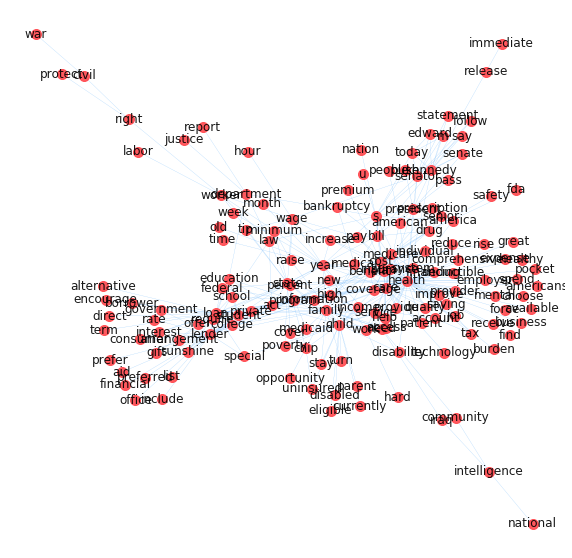

In [44]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [45]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [46]:
c

[frozenset({'access',
            'account',
            'act',
            'aid',
            'alternative',
            'america',
            'american',
            'americans',
            'arrangement',
            'available',
            'bankruptcy',
            'benefit',
            'bill',
            'borrower',
            'burden',
            'bush',
            'business',
            'care',
            'child',
            'chip',
            'choose',
            'civil',
            'college',
            'community',
            'comprehensive',
            'consumer',
            'cost',
            'cover',
            'coverage',
            'currently',
            'deductible',
            'department',
            'direct',
            'disability',
            'disabled',
            'drug',
            'education',
            'edward',
            'eligible',
            'employer',
            'encourage',
            'expense',
            'family',
   

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [47]:
giant = nx.Graph(giant)

In [48]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 431
Average degree:   5.5974


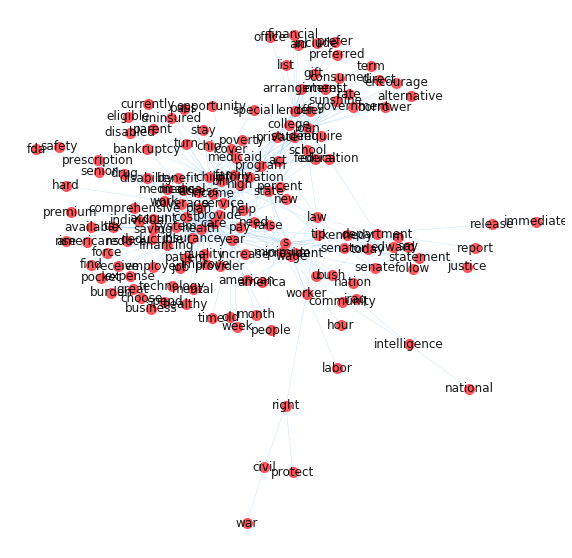

In [49]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [50]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

loan, lender, student, college, family, act


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [51]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 11
Average degree:   4.4000


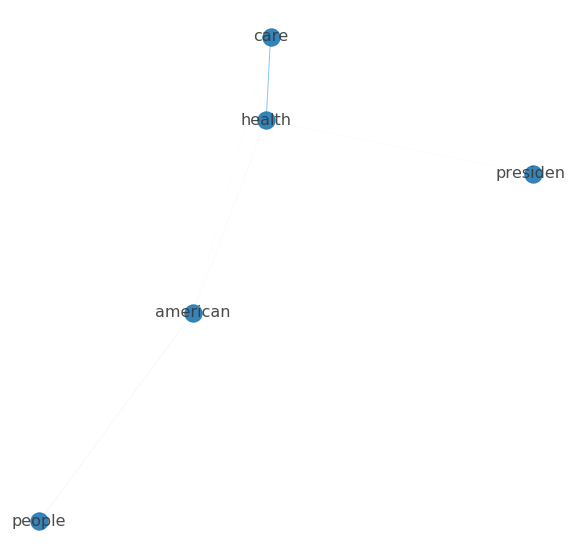

In [52]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [53]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [54]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 419
Average degree:   5.6242


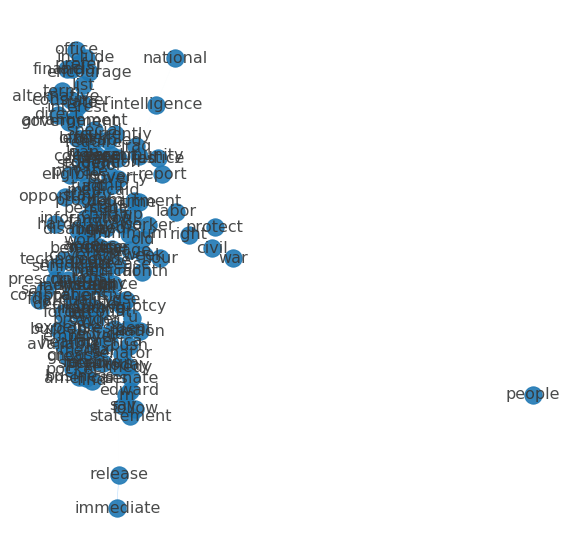

In [55]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [25]:
Papers = pandas.read_csv('data1.csv')
Papers.drop(Papers[pandas.isnull(Papers['text'])].index,axis=0,inplace=True)
Papers[:3]

Article Title              Author  \
0  (Mis)perceptions of Domestic Politics in the U...      Millwood, Pete   
1     30 Years After Tiananmen: Dissent Is Not Dead.  Economy, Elizabeth   
2     30 Years After Tiananmen: Hong Kong Remembers.          Tai, Benny   

          Journal Title                       Publisher  \
0    Diplomatic History   Oxford University Press / USA   
1  Journal of Democracy  Johns Hopkins University Press   
2  Journal of Democracy  Johns Hopkins University Press   

                                            Subjects Keywords  \
0  HISTORY; DIPLOMATIC history; DIPLOMACY; CHINA-...      NaN   
1  HUMAN rights; INTERNATIONAL relations; CHINESE...      NaN   
2  DEMONSTRATIONS (Collective behavior); CHINESE ...      NaN   

                                                text  
0  The article discusses the influence of U.S. an...  
1  In developments that form a stark contrast to ...  
2  The three landmark events in Hong Kong's ongoi...

In [26]:
Papers['tokenized_sents'] = Papers['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
Papers['normalized_sents'] = Papers['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [10]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [11]:
g = wordCooccurrence(Papers['normalized_sents'][:100].sum())

In [12]:
len(g.nodes)

2665

In [13]:
len(g.edges)

55769

In [14]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [16]:
import sklearn.feature_extraction


In [17]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(Papers['text'][:100])

In [18]:
senVects_incidence.shape

(100, 2665)

In [19]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [20]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 2765
Number of edges: 6622
Average degree:   4.7899


C:\Users\11502\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\11502\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\11502\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\11502\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\11502\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21338 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\11502\Anaconda3\lib\site-packages\matplotlib\b

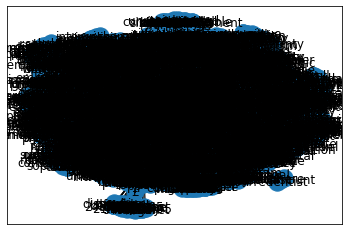

In [21]:
nx.draw_networkx(g_2mode)

In [22]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [23]:
gDoc = contractNetwork(g_2mode, 'doc')

In [24]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4787
Average degree:  95.7400


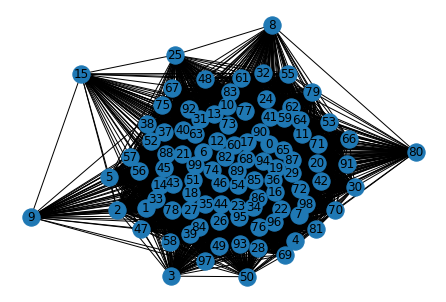

In [25]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

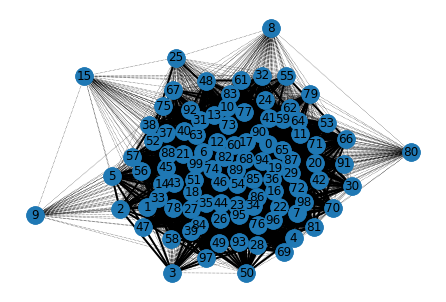

In [26]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [28]:
print(len(Papers.iloc[8]['text']),"words:","\n",Papers.iloc[8]['text'].strip().replace('  ', '\n'))

86 words: 
 China and Russia share similar views of what a future Eurasian order should look like.


In [29]:
print(len(Papers.iloc[9]['text']),"words:","\n",Papers.iloc[9]['text'].strip().replace('  ', '\n'))

156 words: 
 If the US alliance system in the Asia-Pacific endures the current divergence of strategic aims and national identities, it will do so under enormous stress.


In [30]:
print(len(Papers.iloc[68]['text']),"words:","\n",Papers.iloc[68]['text'].strip().replace('  ', '\n'))

1856 words: 
 This article investigates whether the People's Republic of China and Japan perceive each other as rivals in Latin America (LA; both the Chinese and Japanese governments tend to refer to the region as Latin America and the Caribbean (LAC), but for the purposes of this article we focus mainly on LA), and what impact such a perception might have on their foreign policy decision-making. We take LA as a case study because China's and Japan's recent (re-)engagement there began almost simultaneously in the early 2000s, and has developed against the background of domestic leadership transitions, growing demands for energy and markets, as well as international political agendas in which LA might play a key role. Developing the work of Thompson [(1995). Principal rivalries. Journal of Conflict Resolution, 39 (2), 195–223; (2001). Identifying rivals and rivalries in world politics. International Studies Quarterly, 45(4), 557–586] and Vasquez [(1993). The War Puzzle. Cambridge, MA: C

In [31]:
print(len(Papers.iloc[89]['text']),"words:","\n",Papers.iloc[89]['text'].strip().replace('  ', '\n'))

2116 words: 
 Highlights • In SSA, Chinese-controlled mines are associated with more local unemployment relative to non-Chinese mining operations. • Citizens' beliefs that Chinese firms are taking local jobs contribute to a negative image of China within mining regions. • Chinese companies' competitive advantage in the use of expatriate labor may explain our findings. Abstract China's increasing investments in African countries have attracted considerable media attention and are the subject of scholarly debate. However, the socioeconomic impacts of China's presence in Africa remain poorly understood. While some case studies maintain that Chinese projects have an enclave character and have largely failed to promote economic spillovers and local employment, others claim that Chinese activities have in fact encouraged infrastructural development and local economic activity. Focusing on the labor market effects of foreign mining investments in Africa, this article examines whether Chinese-

In [32]:
print(len(Papers.iloc[82]['text']),"words:","\n",Papers.iloc[82]['text'].strip().replace('  ', '\n'))

842 words: 
 English-language analysis of Chinese foreign policy has often cited nationalist public opinion as a key driver of Beijing's recent assertive maritime conduct. Yet these important conjectures have not been systematically tested. How can we know whether public opinion has been driving an authoritarian state's foreign policy? What are some cases in which concern about popular nationalism may have influenced Beijing's behavior in disputed maritime spaces? To answer these questions, this article constructs a methodological framework for assessing the likely impact of public opinion on particular instances of state action. Applying this to five cases typical of China's on-water policy in the South and East China Seas since 2007 indicates that popular nationalism has had little to do with China's assertive turn on its maritime periphery.


## Comments

An interestimg finding is that there seems no clear pattern what kind of paper goes in the center and what is marginalized. The two examples from outside are related to international relations, however in the center there are also papers related to China's international relations.

In [34]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 2665
Number of edges: 211593
Average degree: 158.7940


In [35]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.1526231964195413

In [36]:
g = wordCooccurrence(Papers['normalized_sents'][:100].sum())

In [37]:
len(g)

2665

In [38]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [39]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [40]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [41]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 6
Average degree:   2.4000


## Comments
Clearly, 25 is too large as a threshold. The number of nodes is decreased by too much.

In [42]:
g = wordCooccurrence(Papers['normalized_sents'][:100].sum())

In [43]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 10])

In [44]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [45]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 70
Average degree:   3.3333


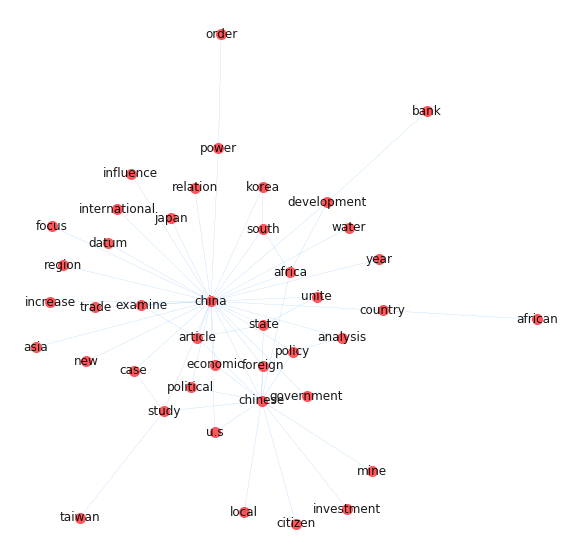

In [46]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

## Comments
It is within our expectation that the two centers are "China" and "Chinese". I actually collected papers regarding China on purpose. It's also interesting to see how they reder to China. The regions associated with China are Japan, Afraica, Taiwan, etc. Many of the papers are focusing on international affairs in China.

In [48]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [49]:
c

[frozenset({'africa',
            'african',
            'analysis',
            'article',
            'asia',
            'bank',
            'case',
            'china',
            'chinese',
            'citizen',
            'country',
            'datum',
            'development',
            'economic',
            'examine',
            'focus',
            'foreign',
            'government',
            'increase',
            'influence',
            'international',
            'investment',
            'japan',
            'korea',
            'local',
            'mine',
            'new',
            'order',
            'policy',
            'political',
            'power',
            'region',
            'relation',
            'south',
            'state',
            'study',
            'taiwan',
            'trade',
            'u.s',
            'unite',
            'water',
            'year'})]

In [50]:
giant = nx.Graph(giant)

In [51]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 500]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 70
Average degree:   3.3333


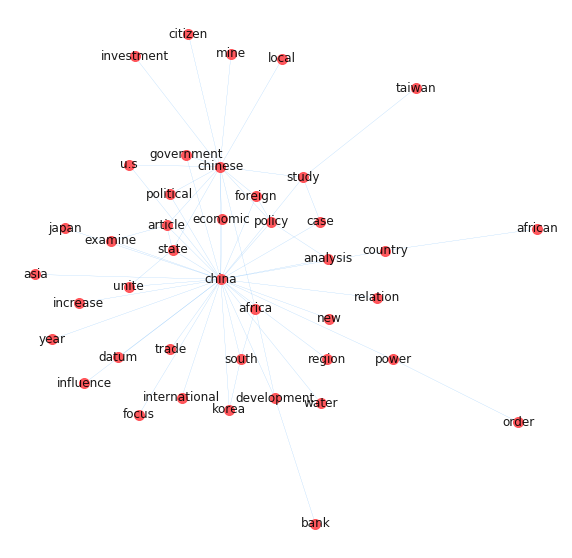

In [52]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [53]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

china, chinese, policy, foreign


In [57]:
africanNeighbors = giant.neighbors('africa')
g_african = giant.subgraph(africanNeighbors)
print(nx.info(g_african))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 12
Average degree:   4.8000


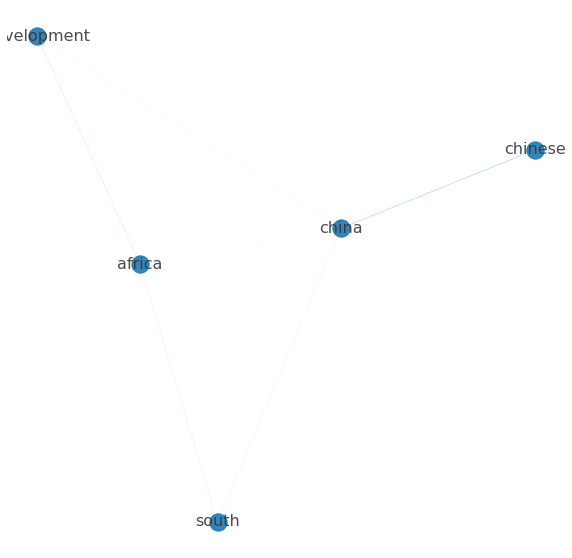

In [58]:
layout_amer = nx.spring_layout(g_african, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_african.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_african.edges(data = True)))
nx.draw(g_african, ax = ax, pos = layout_amer, labels = {n:n for n in g_african.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_african.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [59]:
africanNeighbors = gWord.neighbors('africa')
africanNeighborsPlus1 = set(africanNeighbors)
for n in africanNeighbors:
    africanNeighborsPlus1 |= set(giant.neighbors(n))

In [60]:
g_african2 = giant.subgraph(africanNeighborsPlus1)
print(nx.info(g_african2))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 53
Average degree:   3.0286


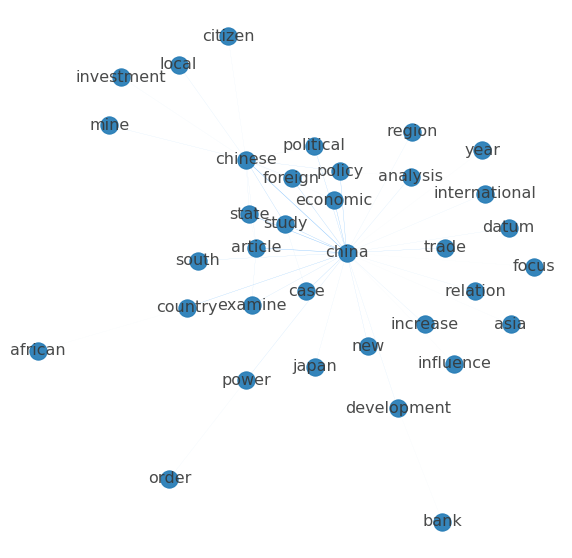

In [61]:
layout_amer = nx.spring_layout(g_african2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_african2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_african2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_african2.edges(data = True)))
nx.draw(g_african2, ax = ax, pos = layout_amer, labels = {n:n for n in g_african2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_african2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [56]:
dcentralities = nx.degree_centrality(giant)

In [57]:
dcentralities['american']

0.0392156862745098

In [58]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.43137254901960786)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

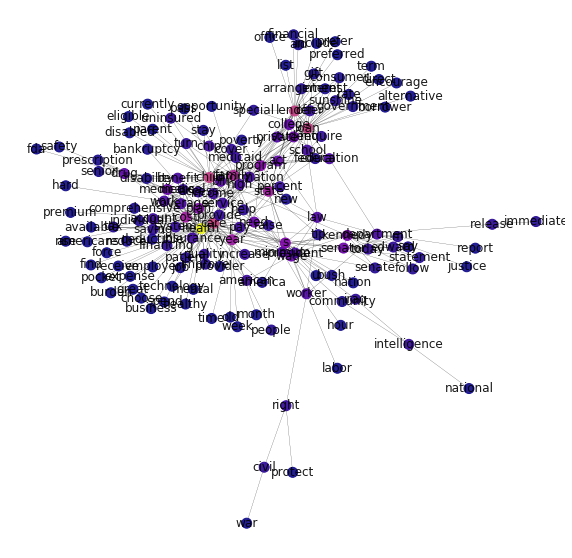

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

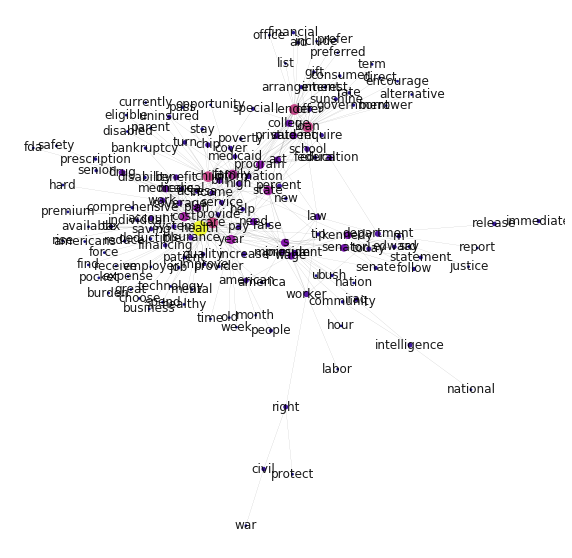

In [60]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

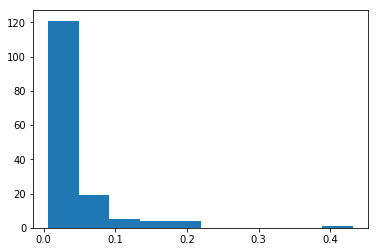

In [61]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [62]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43137254901960786),
 ('care', 0.20915032679738563),
 ('loan', 0.20261437908496732),
 ('lender', 0.20261437908496732),
 ('child', 0.20261437908496732),
 ('family', 0.16993464052287582),
 ('state', 0.1503267973856209),
 ('cost', 0.1503267973856209),
 ('year', 0.14379084967320263),
 ('program', 0.11764705882352941)]

In [63]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('old', 0.006535947712418301),
 ('alternative', 0.006535947712418301),
 ('employer', 0.006535947712418301),
 ('time', 0.006535947712418301),
 ('protect', 0.006535947712418301),
 ('find', 0.006535947712418301),
 ('month', 0.006535947712418301),
 ('choose', 0.006535947712418301),
 ('burden', 0.006535947712418301),
 ('hour', 0.006535947712418301)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [64]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [65]:
centralities['american']

0.013071895424836602

In [66]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.4470172111371691)

We can color and size the nodes by betweenness centrality:

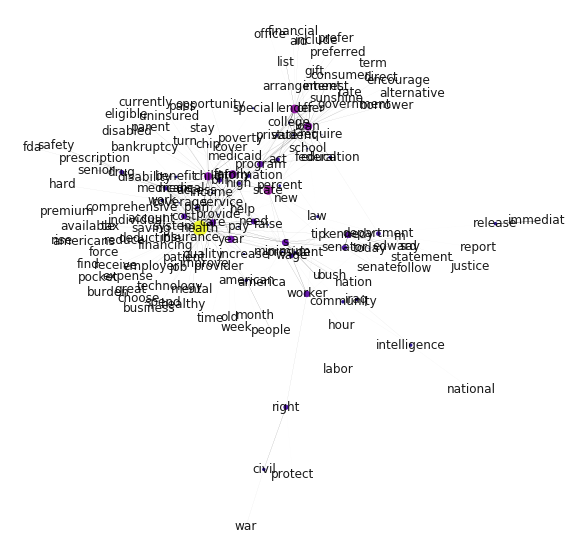

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

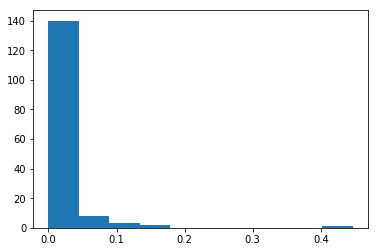

In [68]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [69]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43137254901960786),
 ('care', 0.20915032679738563),
 ('loan', 0.20261437908496732),
 ('lender', 0.20261437908496732),
 ('child', 0.20261437908496732),
 ('family', 0.16993464052287582),
 ('state', 0.1503267973856209),
 ('cost', 0.1503267973856209),
 ('year', 0.14379084967320263),
 ('program', 0.11764705882352941)]

What are words lower down?

In [70]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('offer', 0.032679738562091505),
 ('cover', 0.032679738562091505),
 ('system', 0.032679738562091505),
 ('medicaid', 0.032679738562091505),
 ('raise', 0.026143790849673203),
 ('edward', 0.026143790849673203),
 ('m', 0.026143790849673203),
 ('help', 0.026143790849673203),
 ('iraq', 0.026143790849673203),
 ('financing', 0.026143790849673203)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [71]:
centralities = nx.closeness_centrality(giant)

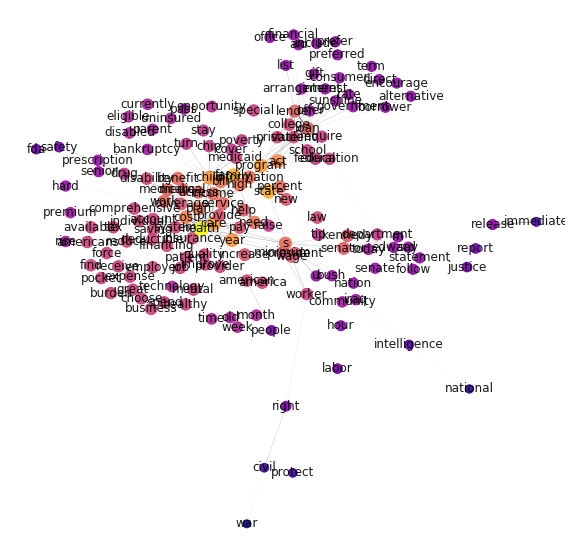

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [73]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.5464285714285714),
 ('family', 0.4811320754716981),
 ('state', 0.478125),
 ('care', 0.4636363636363636),
 ('program', 0.4622356495468278),
 ('child', 0.4540059347181009),
 ('year', 0.4526627218934911),
 ('act', 0.4421965317919075),
 ('cost', 0.4297752808988764),
 ('bill', 0.4214876033057851)]

In [74]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('report', 0.255),
 ('justice', 0.255),
 ('fda', 0.2528925619834711),
 ('safety', 0.2528925619834711),
 ('intelligence', 0.2311178247734139),
 ('immediate', 0.2191977077363897),
 ('civil', 0.20930232558139536),
 ('protect', 0.208731241473397),
 ('national', 0.18796068796068796),
 ('war', 0.17327293318233294)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [75]:
centralities = nx.eigenvector_centrality(giant)

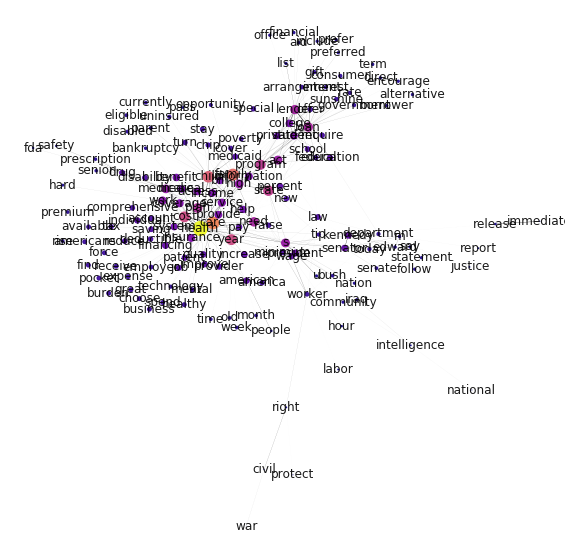

In [76]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

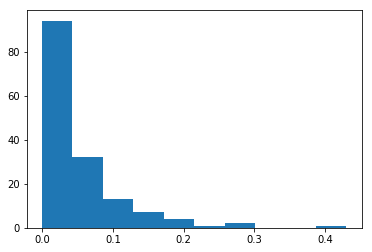

In [77]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [78]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.42995279031459827),
 ('care', 0.2947914920794643),
 ('family', 0.2603644408806845),
 ('child', 0.2382674519067325),
 ('year', 0.2079239618802662),
 ('cost', 0.20661666982150814),
 ('state', 0.18895034623150686),
 ('program', 0.17974768076823017),
 ('plan', 0.16286095340939513),
 ('loan', 0.15444867005457827)]

In [79]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('right', 0.002379491404427387),
 ('labor', 0.0021785593770077536),
 ('intelligence', 0.0018622546091151765),
 ('report', 0.0015865384548653968),
 ('justice', 0.0015865384548653968),
 ('immediate', 0.000447560413509399),
 ('civil', 0.00018917863089936015),
 ('protect', 0.00017430529656646003),
 ('national', 0.00013641034495485814),
 ('war', 1.385814528262875e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [43]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [81]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 112
Average degree:   8.9600


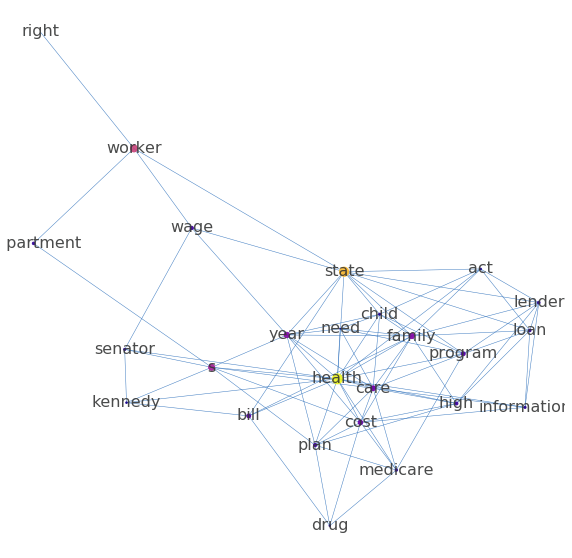

In [82]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [83]:
nx.density(giant)

0.03658433070197776

We can also calculate the average degree per node:

In [84]:
np.mean([v for w,v in nx.degree(giant)])

5.597402597402597

The diameter calculates the average distance between any two nodes in the network:

In [85]:
nx.diameter(giant)

9

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

## Degree Centrality

In [62]:
dcentralities = nx.degree_centrality(giant)

In [64]:
dcentralities['china']

0.8536585365853658

In [65]:
max(dcentralities.items(), key = lambda x : x[1])

('china', 0.8536585365853658)

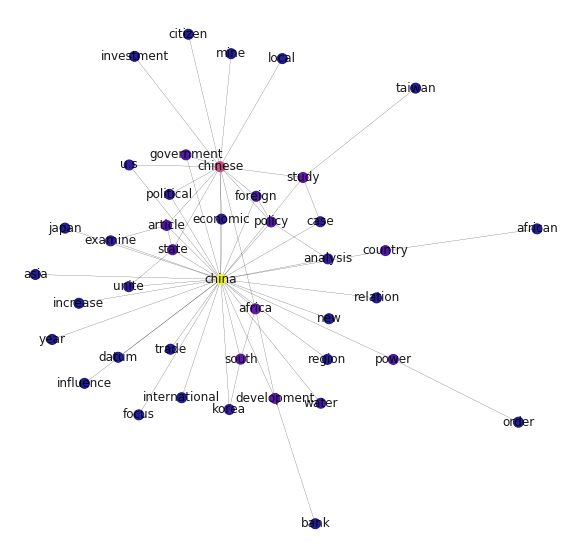

In [66]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

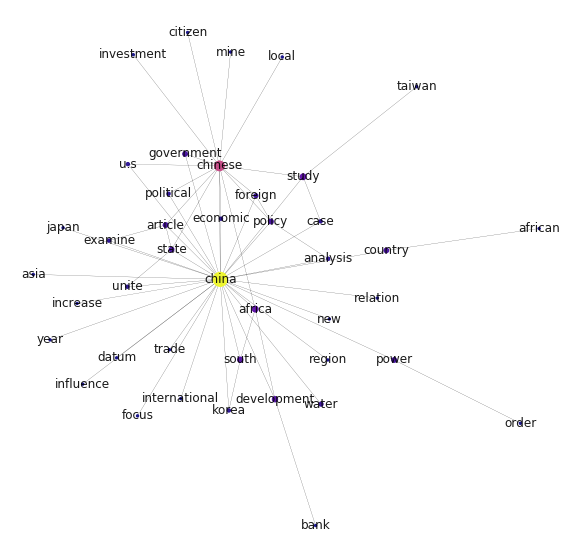

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

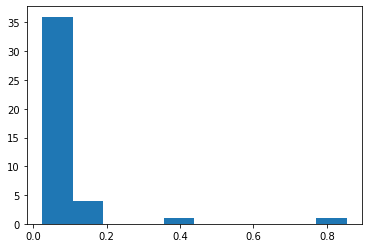

In [68]:
plt.hist(list(dcentralities.values()))
plt.show()

In [69]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('china', 0.8536585365853658),
 ('chinese', 0.41463414634146345),
 ('study', 0.14634146341463417),
 ('africa', 0.14634146341463417),
 ('development', 0.12195121951219512),
 ('south', 0.12195121951219512),
 ('country', 0.0975609756097561),
 ('state', 0.0975609756097561),
 ('article', 0.0975609756097561),
 ('power', 0.0975609756097561)]

In [70]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('mine', 0.024390243902439025),
 ('datum', 0.024390243902439025),
 ('african', 0.024390243902439025),
 ('year', 0.024390243902439025),
 ('local', 0.024390243902439025),
 ('international', 0.024390243902439025),
 ('investment', 0.024390243902439025),
 ('citizen', 0.024390243902439025),
 ('relation', 0.024390243902439025),
 ('asia', 0.024390243902439025)]

## Betweenness Centrality

In [72]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [73]:
centralities['china']

0.8457317073170731

In [74]:
max(centralities.items(), key = lambda x : x[1])

('china', 0.8457317073170731)

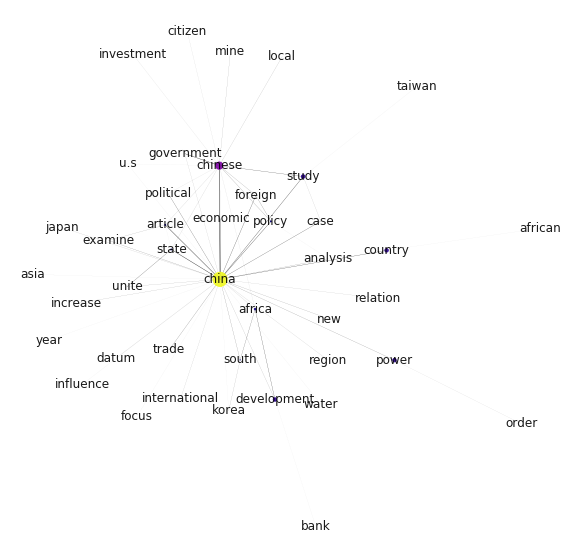

In [75]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

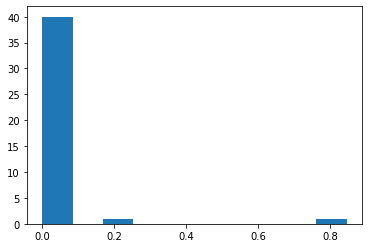

In [76]:
plt.hist(list(centralities.values()))
plt.show()

In [77]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('china', 0.8536585365853658),
 ('chinese', 0.41463414634146345),
 ('study', 0.14634146341463417),
 ('africa', 0.14634146341463417),
 ('development', 0.12195121951219512),
 ('south', 0.12195121951219512),
 ('country', 0.0975609756097561),
 ('state', 0.0975609756097561),
 ('article', 0.0975609756097561),
 ('power', 0.0975609756097561)]

In [86]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('mine', 0.024390243902439025),
 ('datum', 0.024390243902439025),
 ('african', 0.024390243902439025),
 ('year', 0.024390243902439025),
 ('local', 0.024390243902439025),
 ('international', 0.024390243902439025),
 ('investment', 0.024390243902439025),
 ('citizen', 0.024390243902439025),
 ('relation', 0.024390243902439025),
 ('asia', 0.024390243902439025)]

## Closeness Centrality

In [82]:
centralities = nx.closeness_centrality(giant)

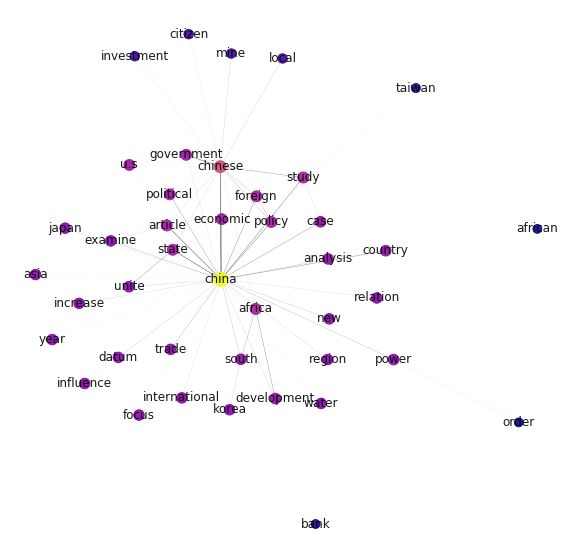

In [83]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [84]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('china', 0.8367346938775511),
 ('chinese', 0.5857142857142857),
 ('study', 0.5061728395061729),
 ('africa', 0.5061728395061729),
 ('state', 0.5),
 ('article', 0.5),
 ('policy', 0.5),
 ('foreign', 0.4939759036144578),
 ('u.s', 0.4880952380952381),
 ('government', 0.4880952380952381)]

In [85]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('relation', 0.4606741573033708),
 ('asia', 0.4606741573033708),
 ('mine', 0.37272727272727274),
 ('local', 0.37272727272727274),
 ('investment', 0.37272727272727274),
 ('citizen', 0.37272727272727274),
 ('taiwan', 0.33884297520661155),
 ('bank', 0.3253968253968254),
 ('order', 0.3228346456692913),
 ('african', 0.3228346456692913)]

## Eigenvector Centrality

In [87]:
centralities = nx.eigenvector_centrality(giant)

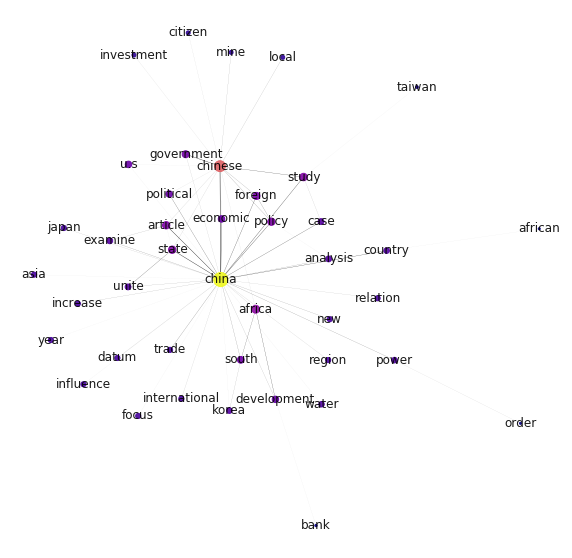

In [88]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

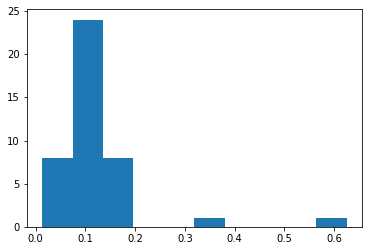

In [89]:
plt.hist(list(centralities.values()))
plt.show()

In [90]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('china', 0.6248602516802428),
 ('chinese', 0.3715988057660521),
 ('africa', 0.19554379851490944),
 ('study', 0.17370581155288167),
 ('state', 0.17005126335872894),
 ('article', 0.17005126335872894),
 ('policy', 0.16808495589953046),
 ('foreign', 0.15559764753507505),
 ('government', 0.15367185761754049),
 ('south', 0.14232940486891946)]

In [91]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('relation', 0.08348953686960736),
 ('asia', 0.08348953686960736),
 ('mine', 0.04965005575101894),
 ('local', 0.04965005575101894),
 ('investment', 0.04965005575101894),
 ('citizen', 0.04965005575101894),
 ('taiwan', 0.023209058721825375),
 ('bank', 0.017260368680864852),
 ('order', 0.013146352003083677),
 ('african', 0.013146352003083677)]

## Comments

Actually, there is no much difference for my dataset using the four kinds of centrality calculation. "China" and "Chinese" are always the central, and the words surrounding them do not vary much. The word lists of high centrality also do not vary much.
There is some minor difference in the least centralized words, though. 

In [92]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [93]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 44
Average degree:   3.5200


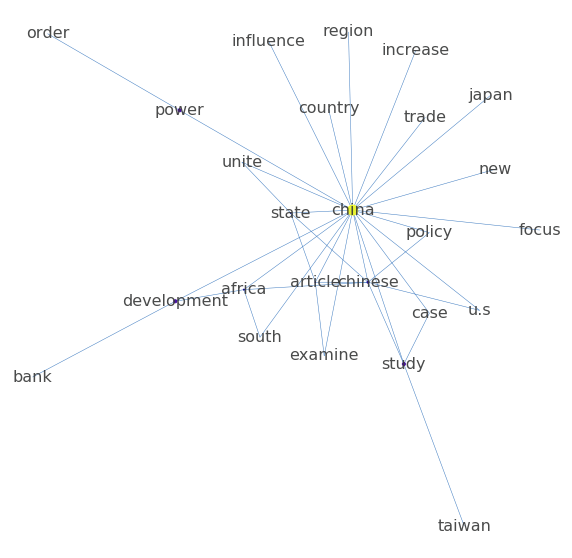

In [94]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [95]:
nx.density(giant)

0.08130081300813008

In [96]:
np.mean([v for w,v in nx.degree(giant)])

3.3333333333333335

In [97]:
nx.diameter(giant)

4

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [86]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [87]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, when,...  
98  [[https://www.reddit.com/r/relationships/comme...  
97  [[First, post, https://www.reddit.com/r/relati...

Now we'll normalize the tokens through stemming:

In [88]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will revisit spacy and use it's english language model.

In [89]:
import spacy

In [90]:
nlp = spacy.load('en')

In [91]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [92]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [93]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2012
Number of edges: 11934
Average degree:  11.8628


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [94]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 221
Average degree:  18.4167


And low weight edges:

In [95]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 80
Average degree:   6.6667


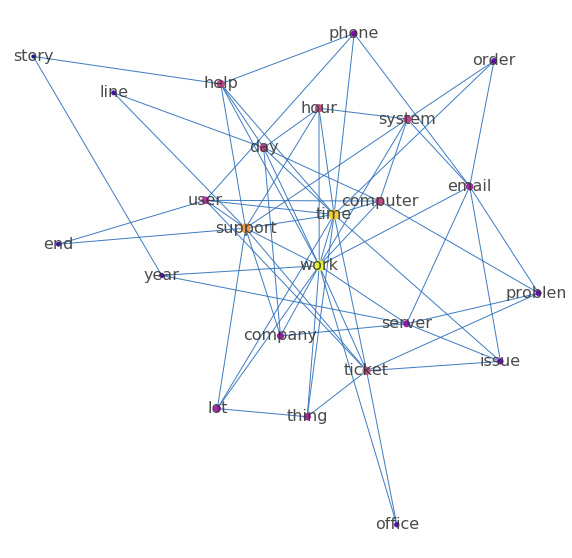

In [96]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [97]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [98]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2161
Number of edges: 18115
Average degree:  16.7654


In [99]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [100]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2161
Number of edges: 5786
Average degree:   5.3549


Dropping low weight edges and low degree vertices gives us:

In [101]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [102]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 50
Average degree:   5.0000


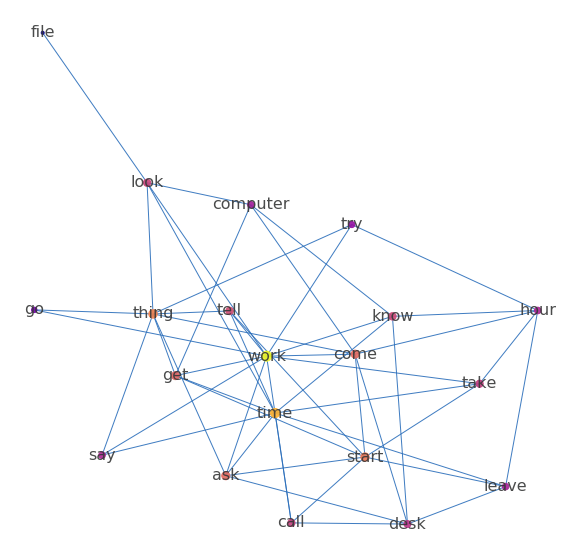

In [103]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [104]:
g_i = gNV.subgraph(['work'] + list(gNV.neighbors('work')))

In [105]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 11
Average degree:   1.8333


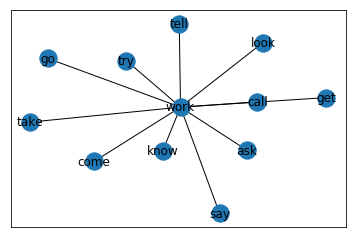

In [106]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [107]:
storyNeighbors = gNV.neighbors('look')
set(storyNeighbors)

{'computer', 'file', 'thing', 'time', 'work'}

In [108]:
storyNeighbors = set(gNV.neighbors('look'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [109]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 33
Average degree:   3.8824


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [110]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.6875),
 ('time', 0.5625),
 ('thing', 0.5),
 ('look', 0.3125),
 ('computer', 0.25),
 ('get', 0.25),
 ('know', 0.1875),
 ('tell', 0.1875),
 ('say', 0.1875),
 ('come', 0.1875)]

Or eigenvector centrality:

In [111]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.45363345471384553),
 ('time', 0.3657602779138192),
 ('thing', 0.3494247945382785),
 ('look', 0.28025415645119023),
 ('get', 0.26921641691621967),
 ('tell', 0.23195961462158712),
 ('say', 0.23195961462158712),
 ('ask', 0.23195961462158712),
 ('know', 0.19987080098426385),
 ('come', 0.1966289183966515)]

Lets plot it:

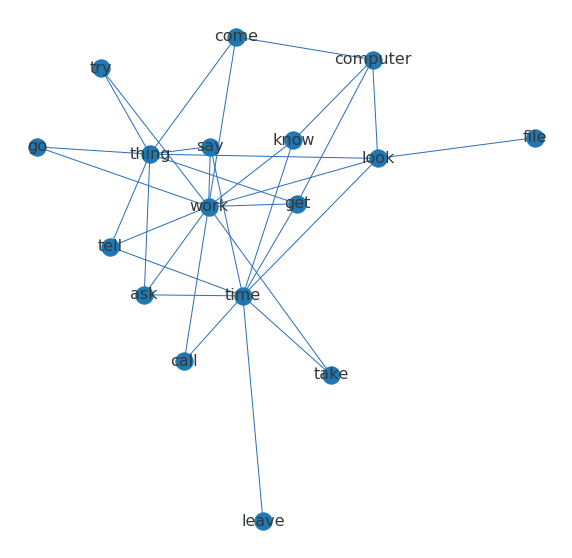

In [112]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Lets create a noun-adjective network:

In [113]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 2683
Number of edges: 20010
Average degree:  14.9161


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [114]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 77
Average degree:   6.1600


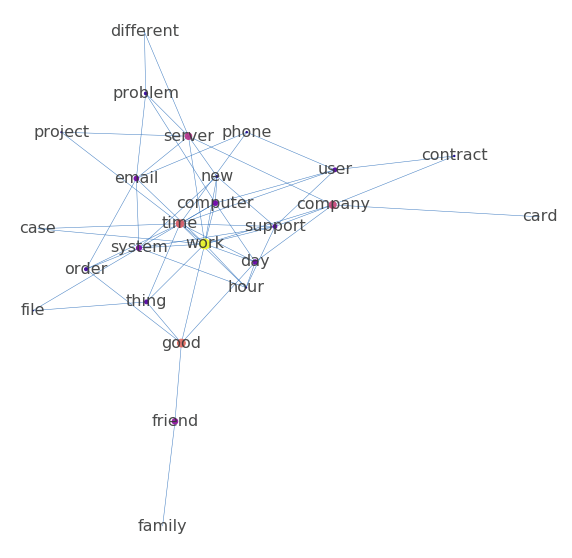

In [115]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [6]:
import spacy

In [7]:
nlp = spacy.load('en')

In [8]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [9]:
gNN = posCooccurrence(Papers['normalized_sents'].sum(), 'NN')

In [10]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 4066
Number of edges: 95953
Average degree:  47.1977


In [11]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 475
Number of edges: 34645
Average degree: 145.8737


The number of nodes is still too large. 

In [12]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 120]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 237
Number of edges: 16327
Average degree: 137.7806


In [13]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 180]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 658
Average degree:  36.5556


In [15]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 9])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 331
Average degree:  18.3889


C:\Users\11502\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


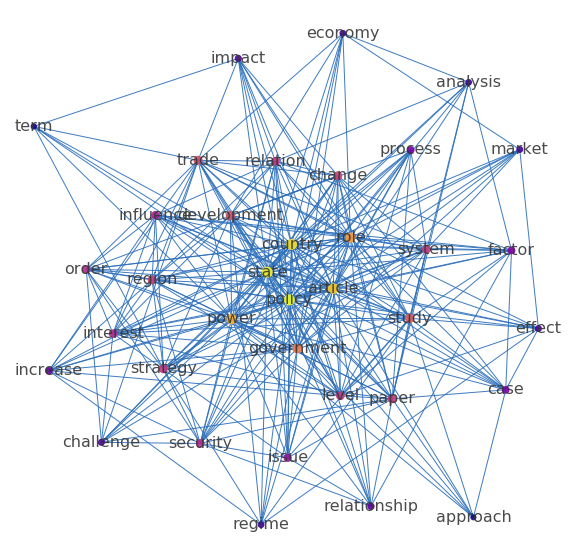

In [16]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [17]:
gNV = posCooccurrence(Papers['normalized_sents'].sum(), 'NN', 'VB')

In [18]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 4283
Number of edges: 118611
Average degree:  55.3869


In [19]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [20]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 4283
Number of edges: 23700
Average degree:  11.0670


In [21]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [22]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 141
Number of edges: 980
Average degree:  13.9007


## Comments 
Still, too many nods and edges.

In [23]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 4])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 8])

In [24]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 108
Average degree:   9.0000


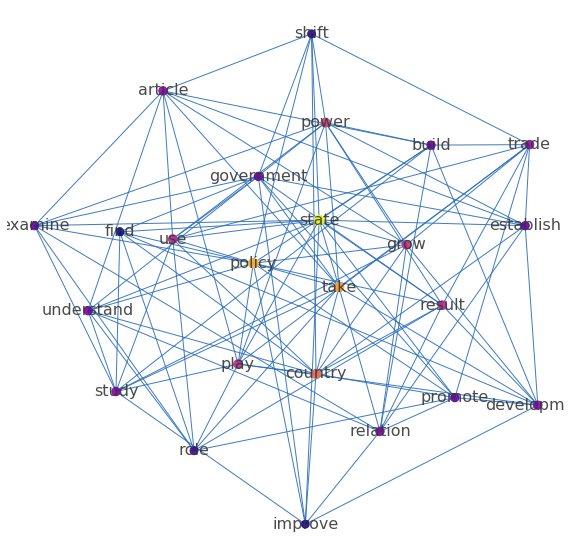

In [25]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [27]:
g_i = gNV.subgraph(['government'] + list(gNV.neighbors('government')))

In [28]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 9
Average degree:   1.8000


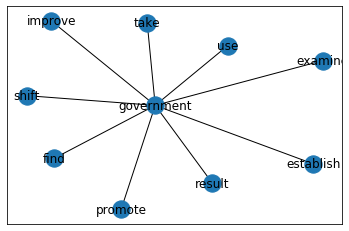

In [29]:
nx.draw_networkx(g_i)

In [30]:
storyNeighbors = gNV.neighbors('shift')
set(storyNeighbors)

{'article', 'country', 'government', 'policy', 'power', 'state', 'trade'}

In [31]:
storyNeighbors = set(gNV.neighbors('government'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [32]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 74
Average degree:   7.4000


In [33]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('take', 0.5789473684210527),
 ('use', 0.47368421052631576),
 ('state', 0.47368421052631576),
 ('government', 0.47368421052631576),
 ('result', 0.47368421052631576),
 ('promote', 0.42105263157894735),
 ('examine', 0.42105263157894735),
 ('policy', 0.42105263157894735),
 ('country', 0.42105263157894735),
 ('establish', 0.42105263157894735)]

In [34]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('take', 0.30020197206599125),
 ('state', 0.2745697757856594),
 ('government', 0.2745697757856594),
 ('result', 0.25967466045527676),
 ('use', 0.25134232357888875),
 ('country', 0.24603526249676547),
 ('policy', 0.24546350852066878),
 ('promote', 0.2348248808299733),
 ('establish', 0.22303407647433368),
 ('examine', 0.21865286816382554)]

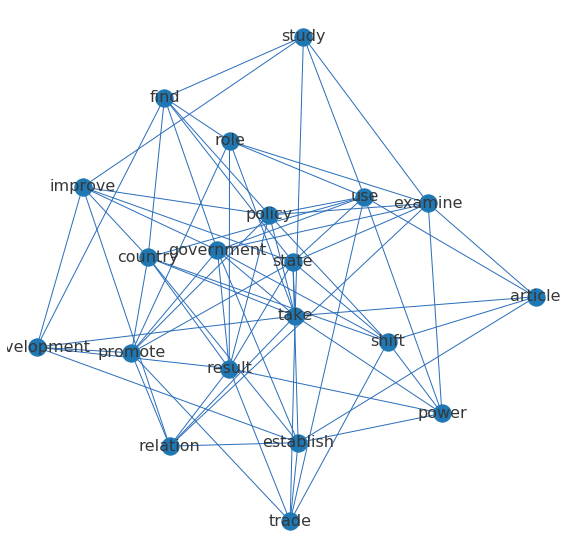

In [35]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [36]:
storyNeighbors = set(gNV.neighbors('government'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))
storyNeighborsPlus2 = set(storyNeighborsPlus1)
for n in storyNeighborsPlus1:
    storyNeighborsPlus2 |= set(gNV.neighbors(n))

In [37]:
gNV_story = gNV.subgraph(storyNeighborsPlus2)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 108
Average degree:   9.0000


In [38]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('state', 0.5652173913043478),
 ('policy', 0.5217391304347826),
 ('country', 0.4782608695652174),
 ('take', 0.4782608695652174),
 ('power', 0.43478260869565216),
 ('grow', 0.3913043478260869),
 ('article', 0.3913043478260869),
 ('use', 0.3913043478260869),
 ('relation', 0.3913043478260869),
 ('study', 0.3913043478260869)]

In [39]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('state', 0.2752896380956296),
 ('policy', 0.2552064015060853),
 ('take', 0.25250993808799316),
 ('country', 0.23485320915262956),
 ('power', 0.2189750469461458),
 ('grow', 0.21301571079032328),
 ('play', 0.21105780169173924),
 ('use', 0.21051092018695164),
 ('result', 0.21013264581342825),
 ('trade', 0.1985870245731109)]

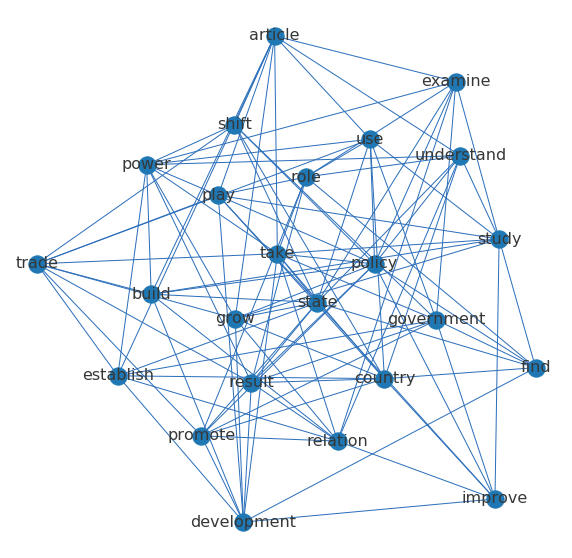

In [40]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [41]:
gNJ = posCooccurrence(Papers['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 1611
Number of edges: 18986
Average degree:  23.5705


In [44]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 83
Average degree:   6.6400


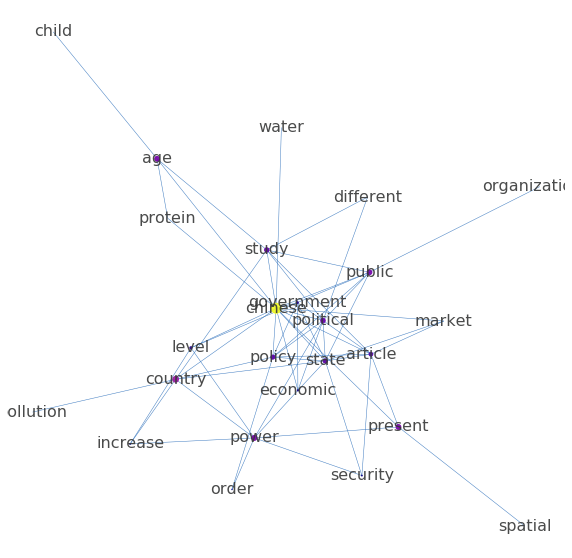

In [45]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## Creating networks of agents from corpora

Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
The code returns a dictionary with each id mapping to the text associated with it. 

We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

This function might take some time.

In [1]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [3]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [4]:
import zipfile

In [5]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [6]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [7]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [8]:
import pandas as pd

In [9]:
soap_dict = {}

In [10]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [11]:
soap_dict.keys()

dict_keys(['One Life to Live', 'As the World Turns', 'Passions', 'Days of Our Lives', 'Guiding Light', 'General Hospital', 'All My Childen', 'Port Charles', 'Bold and Beautiful', 'Young and Restless'])

In [12]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [13]:
i = 0

In [14]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

One Life to Live
As the World Turns
Passions
Days of Our Lives
Guiding Light
General Hospital
All My Childen
Port Charles
Bold and Beautiful
Young and Restless


In [15]:
soap_df

Soap Name                                    Tokenized Texts
0    One Life to Live  [@!Blair, Excuse, me, @!Todd, Why, Did, you, d...
1  As the World Turns  [@!Katie, Okay, I, know, these, words, are, lo...
2            Passions  [@!Julian, Let, 's, drink, up, It, 's, not, ev...
3   Days of Our Lives  [@!Maggie, How, are, you, doing, @!Victor, Fin...
4       Guiding Light  [@!Dax, I, take, it, everything, is, well, wit...
5    General Hospital  [@!Luke, I, signed, my, divorce, papers, You, ...
6      All My Childen  [@!Reporter, Is, there, anything, you, regret,...
7        Port Charles  [@!Frank, Hey, @!Karen, Hey, You, still, on, d...
8  Bold and Beautiful  [@!Bridget, What, did, you, say, @!Deacon, Jus...
9  Young and Restless  [@!Katherine, Any, sign, of, your, daddy, swee...

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 9th corpora, and I conducted my basic analysis on that.

In [16]:
dool = soap_df['Tokenized Texts'][3]

In [17]:
' '.join(dool[0:1500])

"@!Maggie How are you doing @!Victor Fine @!Nicole Humming this ought to ease the pain @!Victor You wo n't be offended if I tell you I 'm not in the mood @!Nicole Oh come on @!Victor Looking around at what 's been going on here I hardly see what we have to toast to @!Nicole How about to us To survivors @!Maggie You all right @!Nicole Yeah @!Maggie Okay @!Philip Hey Chloe @!Chloe How 's Lexie @!Philip Does n't look so good but John and Marlena did everything they can How are you How are you holding up @!Chloe I 'm fine Philip okay I just need to be alone @!John It 's not enough Wounds are too severe @!Marlena We have no choice She 's got to get to the hospital @!Maggie Okay @!Hope Is there any news @!Maggie Mickey said there were explosions all over town and no one knows why Most of the roads are still blocked and they 're telling My daughter There 's no time We have to get her to the hospital @!Maggie Even if the roads were clear Stefano the ambulances are all in use There are victims 

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [18]:
characters = {}

In [19]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [248]:
len(characters)

908

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [21]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

John 2403
Lucas 2380
Brady 2183
Jennifer 2163
Nicole 3399
Hope 3520
Belle 2783
Philip 2568
Bo 3830
Sami 5246
Kate 2419
Shawn 2952


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

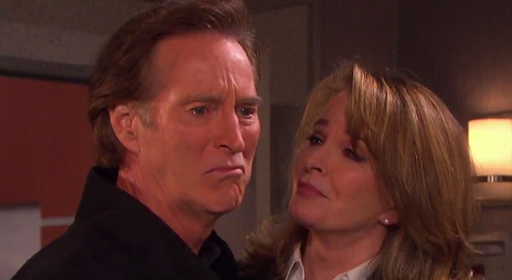

In [135]:
Image(filename='../data/dool/dool_john.png') 

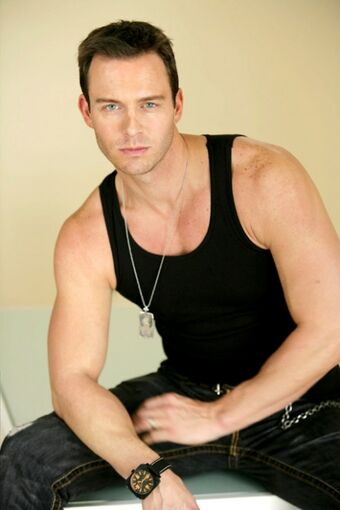

In [136]:
Image(filename='../data/dool/dool_brady.jpg') 

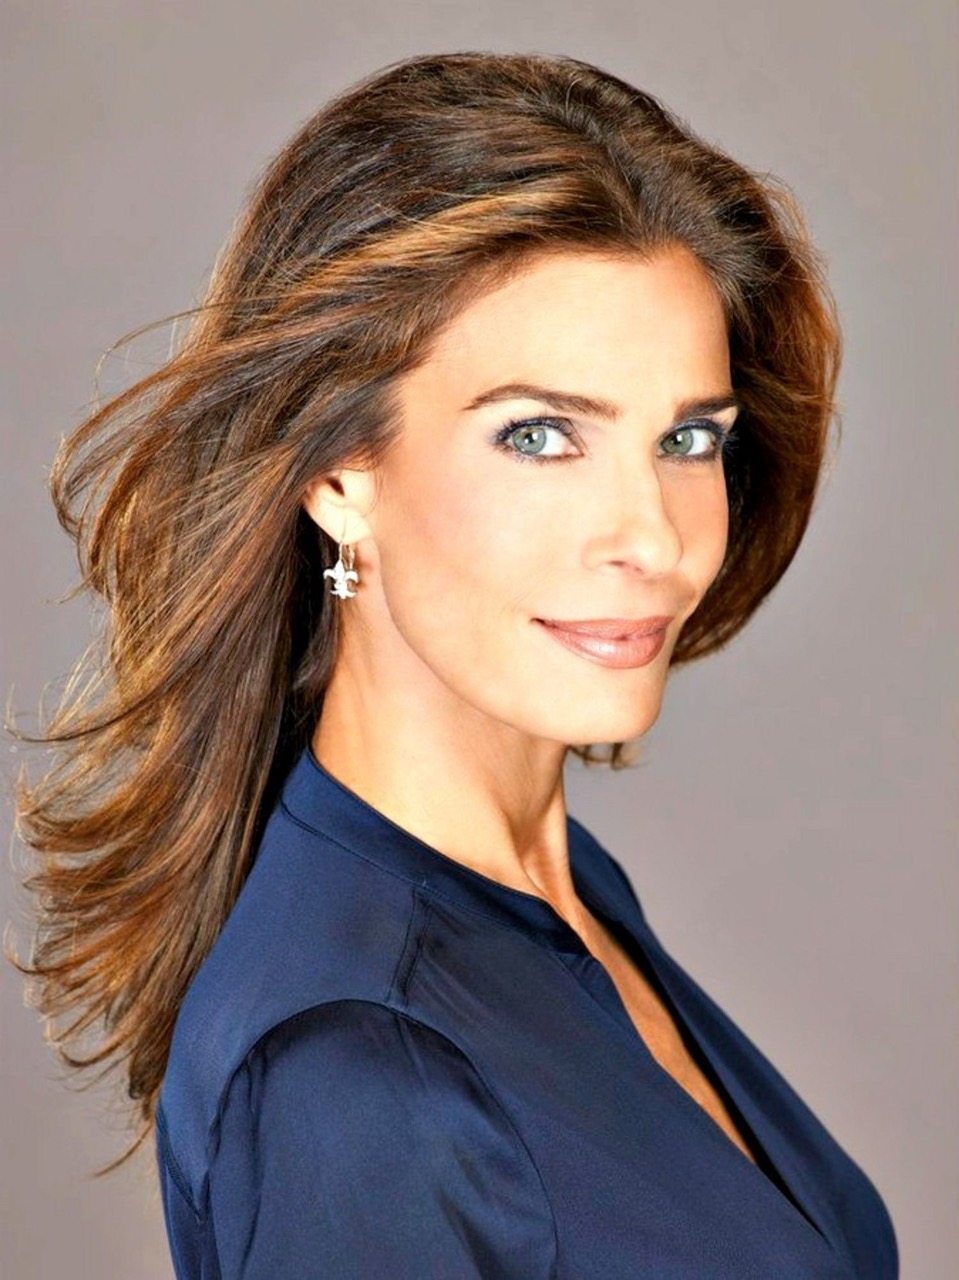

In [139]:
Image(filename='../data/dool/dool_hope.jpeg')

In [141]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [224]:
# Image(filename='../data/dool/dool_marlena.jpg')

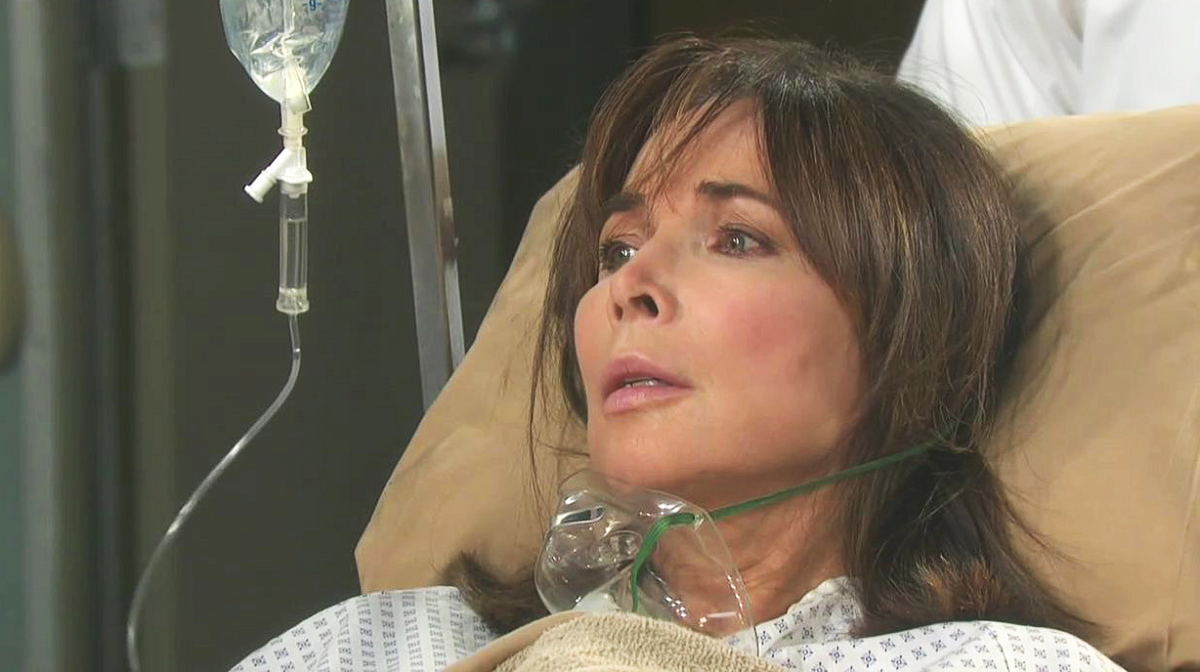

In [143]:
Image(filename='../data/dool/dool_kate.png')

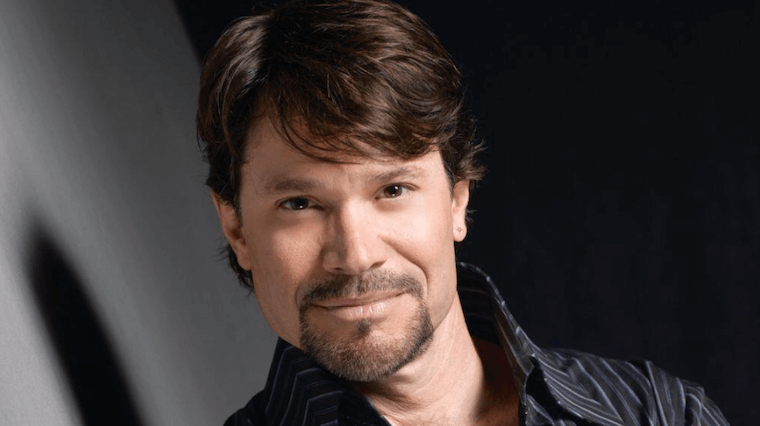

In [144]:
Image(filename='../data/dool/dool_bo.png')

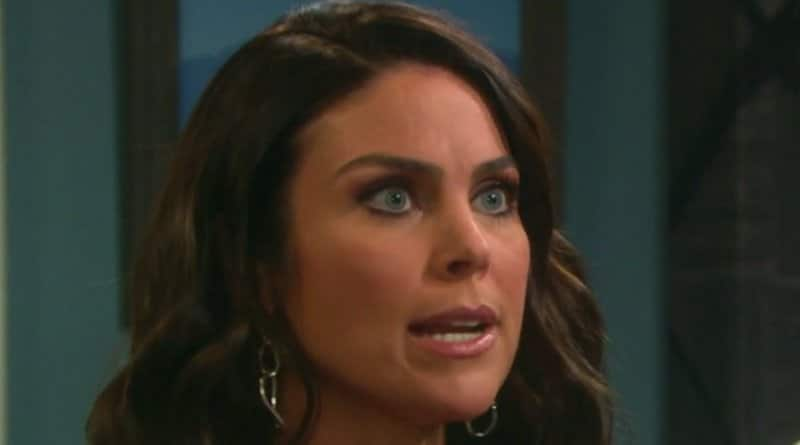

In [145]:
Image(filename='../data/dool/dool_chloe.jpg')

In [148]:
# Image(filename='../data/dool/dool_sami.jpg')

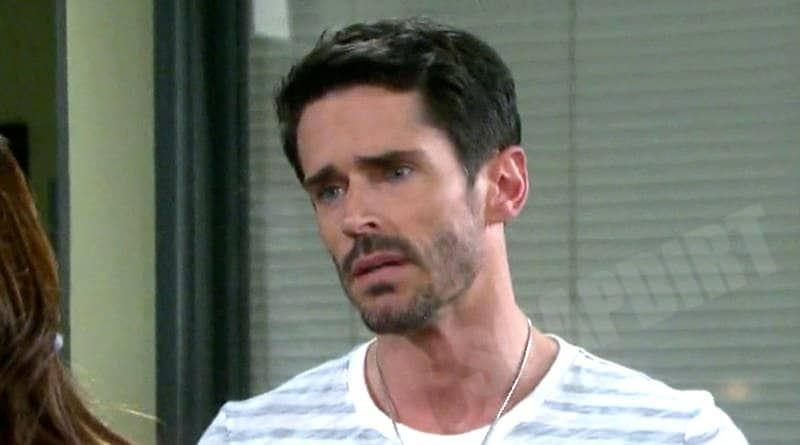

In [149]:
Image(filename='../data/dool/dool_shawn.jpg')

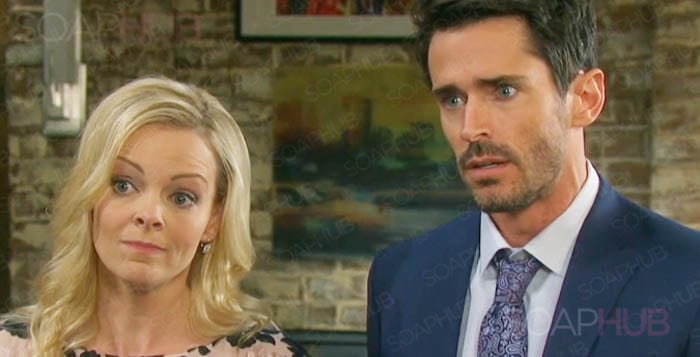

In [150]:
Image(filename='../data/dool/dool_belle.jpg')

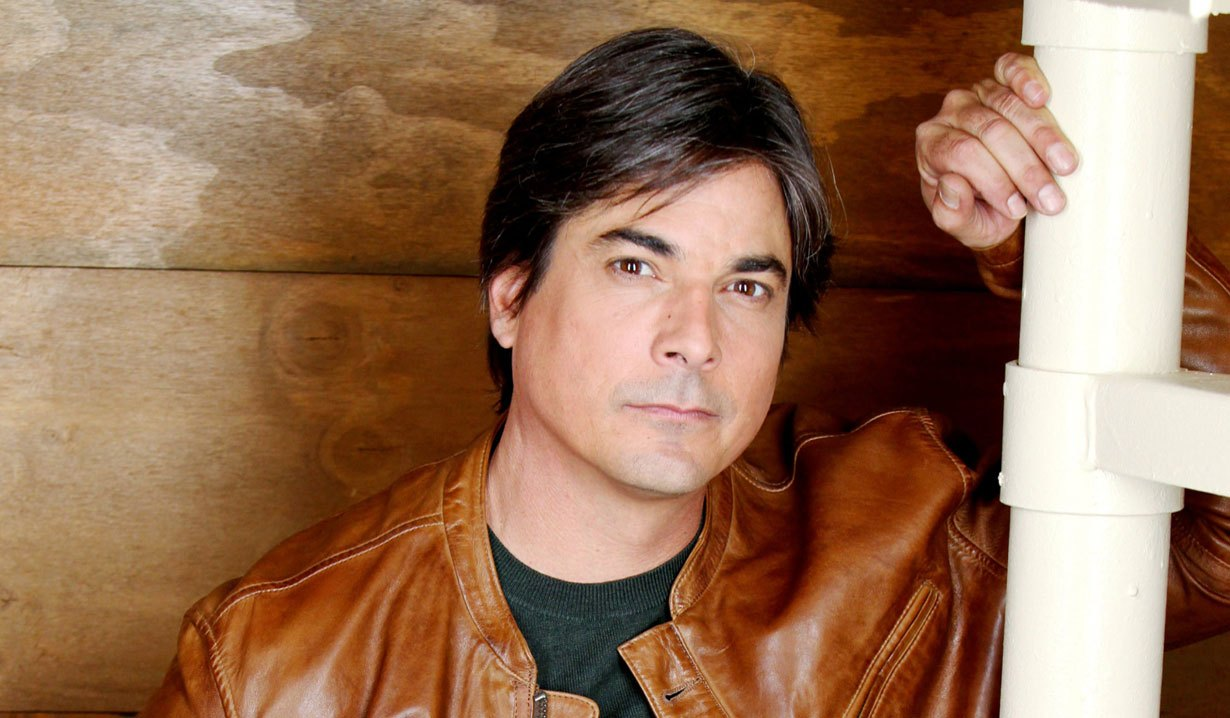

In [151]:
Image(filename='../data/dool/dool_lucas.jpg')

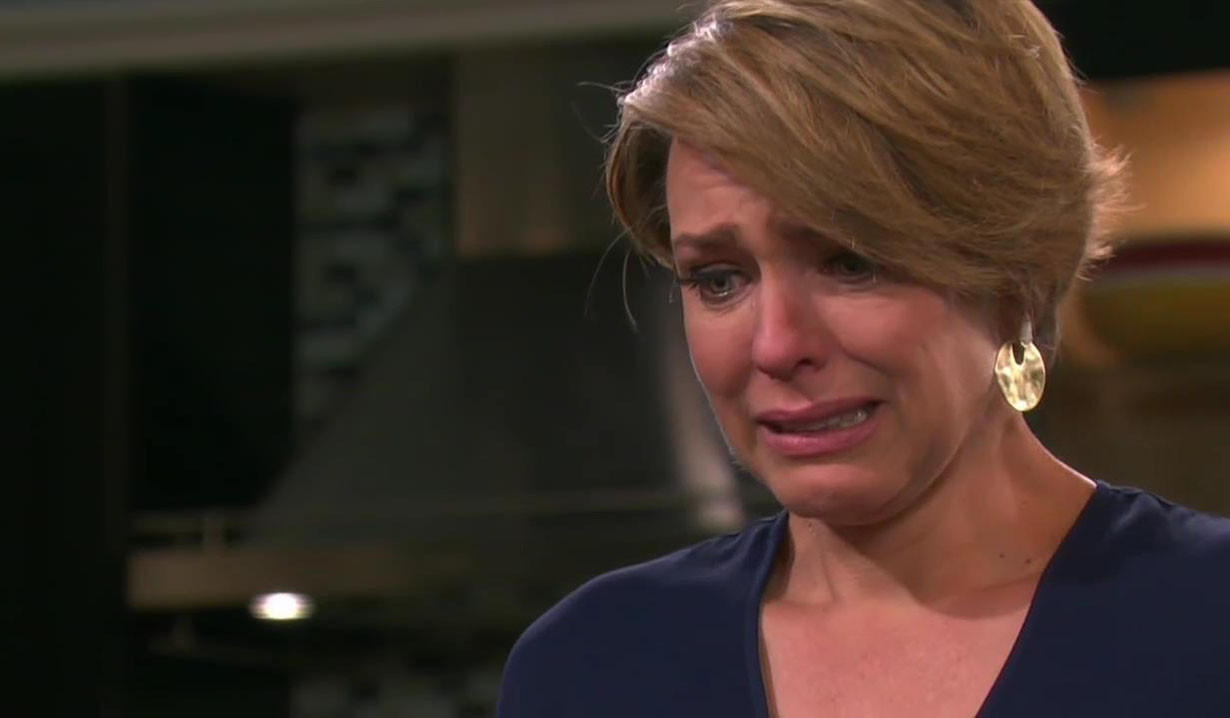

In [152]:
Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [22]:
actor_network = nx.Graph()

In [23]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [24]:
len(actor_network.nodes.data())

12

In [25]:
actor_network.nodes.data()

NodeDataView({'Hope': {'words': [], 'lines_spoken': 3520}, 'Kate': {'words': [], 'lines_spoken': 2419}, 'Lucas': {'words': [], 'lines_spoken': 2380}, 'Belle': {'words': [], 'lines_spoken': 2783}, 'Nicole': {'words': [], 'lines_spoken': 3399}, 'Philip': {'words': [], 'lines_spoken': 2568}, 'Brady': {'words': [], 'lines_spoken': 2183}, 'John': {'words': [], 'lines_spoken': 2403}, 'Shawn': {'words': [], 'lines_spoken': 2952}, 'Sami': {'words': [], 'lines_spoken': 5246}, 'Jennifer': {'words': [], 'lines_spoken': 2163}, 'Bo': {'words': [], 'lines_spoken': 3830}})

In [26]:
actor_network.nodes['Sami']['lines_spoken']

5246

In [27]:
i = 0

The following lines of code creates the graph. Please carefully go through the code: you should be able to understand (more or less) what is going on here. 

In [28]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

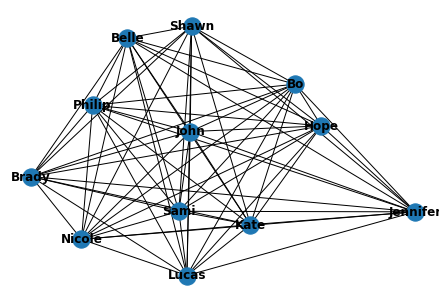

In [29]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [30]:
import seaborn as sns

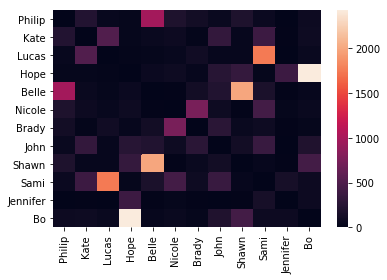

In [31]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [32]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [33]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'Jennifer',
            'John',
            'Kate',
            'Lucas',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [55]:
smaller_actor_network = nx.Graph()

In [56]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


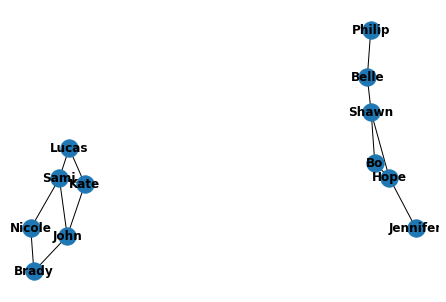

In [57]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [53]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [54]:
c

[frozenset({'Brady', 'John', 'Kate', 'Lucas', 'Nicole', 'Sami'}),
 frozenset({'Belle', 'Bo', 'Hope', 'Jennifer', 'Philip', 'Shawn'})]

In [59]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [63]:
dcentralities['John'], dcentralities['Philip']

(0.2727272727272727, 0.09090909090909091)

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [262]:
import nltk

In [263]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [264]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [265]:
L = []

In [266]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

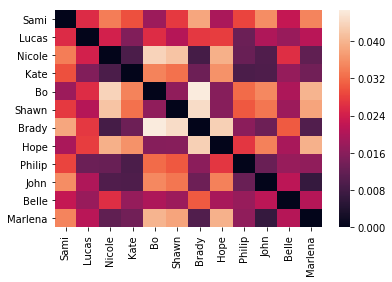

In [267]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [268]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [209]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [210]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [211]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [212]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

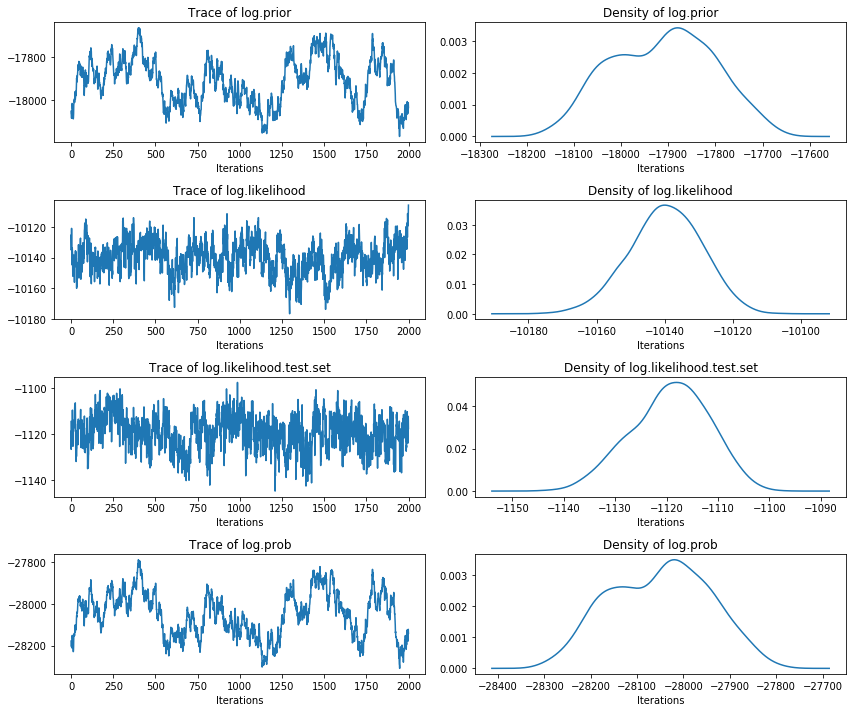

In [213]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [214]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [215]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [216]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [217]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


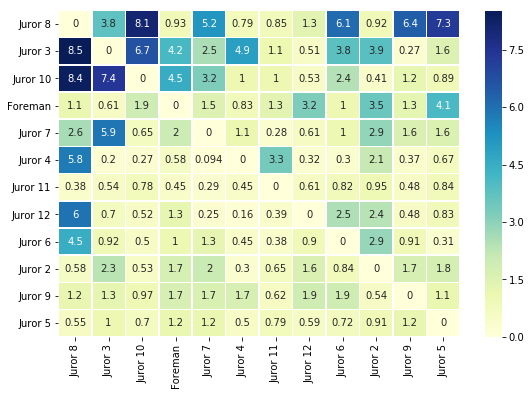

In [218]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


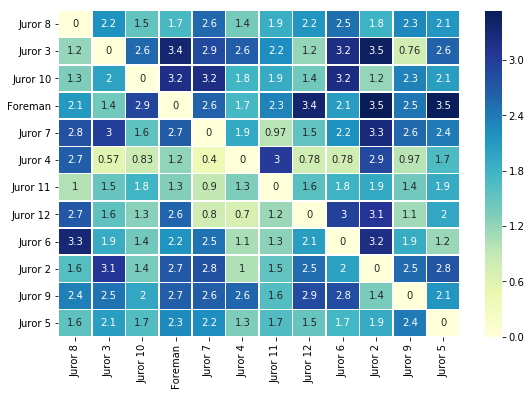

In [219]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [220]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


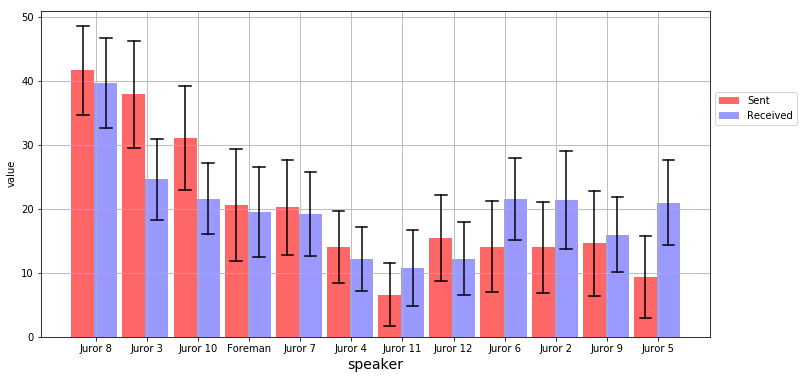

In [221]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [222]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [223]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


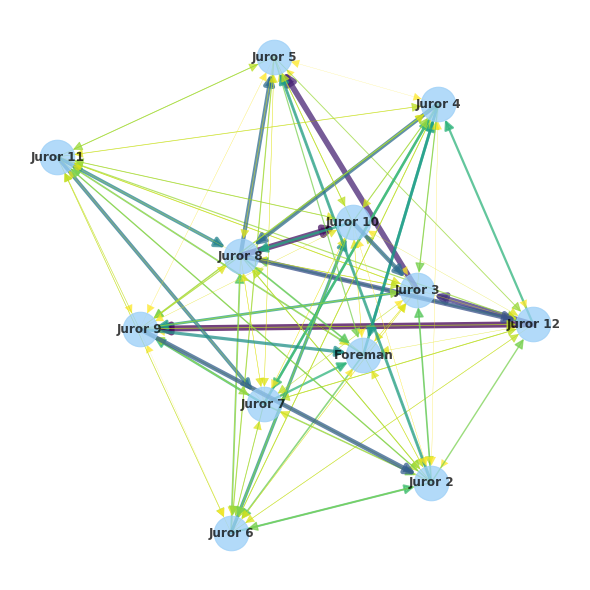

In [187]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


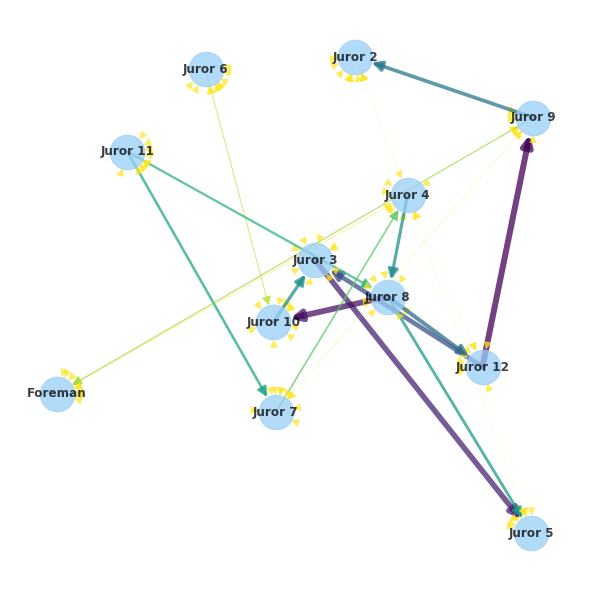

In [188]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


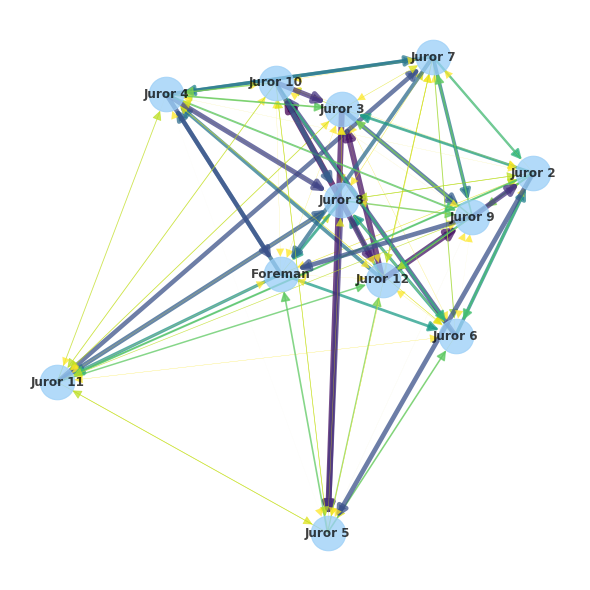

In [189]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [190]:
import lucem_illud_2020
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [191]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Kennedy  [chic, lfca, echd, ekfh, gcgl, kjsb, bhgk, sjh...  0.282216   
1    Obama  [bses, bbhl, khfs, blls, lbbi, bebh, bldg, skc...  2.711259   

        end  
0  1.451031  
1  3.377750

Transform data into TalkbankXML format:

In [192]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [193]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [9]:
# Papers[:3]

In [10]:
# def tag_sents_ner(sentences):
#     """
#     function which replicates NLTK ner tagging on sentences.
#     """
#     new_sents = []
#     for sentence in sentences:
#         new_sent = ' '.join(sentence)
#         new_sents.append(new_sent)
#     final_string = ' '.join(new_sents)
#     doc = nlp(final_string)
    
#     pos_sents = []
#     for sent in doc.sents:
#         pos_sent = []
#         for ent in sent.ents:
#             pos_sent.append((ent.text, ent.label_))
#         pos_sents.append(pos_sent)
    
#     return pos_sents

In [11]:
# Papers['classified_sents'] = Papers['tokenized_sents'].apply(lambda x: tag_sents_ner(x))

In [12]:
# Papers[:3]

In [13]:
# actors = {}
# for entry in Papers['classified_sents']:
#     for sentence in entry:
#         for ent, kind in sentence:
#             if kind == 'ORG':
#                 continue
#             elif ent in actors:
#                 actors[ent] += 1
#             else:
#                 actors[ent] = 1
            

In [32]:
# len(actors)

2662

In [14]:
# for actor in actors:
#     if actors[actor] > 50:
#         print(actor, actors[actor])

In [34]:
# actor_network = nx.Graph()

In [35]:
# for actor in actors:
#     if actors[actor] > 50:
#         actor_network.add_node(actor, lines_spoken= actors[actor], words=[])

In [15]:
# len(actor_network.nodes.data())

In [16]:
# actor_network.nodes.data()

In [17]:
# actor_network.nodes['Japan']['lines_spoken']

In [39]:
# actors = {}
# for entry in Papers['classified_sents']:
#     for sentence in entry:
#         for ent, kind in sentence:
#             if kind == 'ORG':
#                 continue
#             elif ent in actors:
#                 actors[ent] += 1
#             else:
#                 actors[ent] = 1

In [40]:
# def convey(tokenized_sents):
#     list1=[]
#     for i in tokenized_sents:
#         for j in i:
#             for k in j: 
#                 list1.append(k)
#     return list1


In [41]:
# dool=convey(Papers['tokenized_sents'])

In [18]:
# dool[:10]

In [43]:
# i=0
# for token in dool:
#     i += 1
#     if i > len(dool):
#         break
#     if token in actors:
#         if token in actor_network.nodes():
#             j = i
#             for token_ in dool[i:]:
#                 if token_ in actor:
#                     # if both the characters exist in the graph, add a weight
#                     if token_ != token and token_ in actor_network.nodes():
#                         if (token, token_) not in actor_network.edges():
#                             actor_network.add_edge(token, token_, weight=0)
#                         if (token, token_) in actor_network.edges():
#                             actor_network.edges[(token, token_)]['weight'] += 1
#                     break
#                 j += 1
#             # adding characters sentences
#             actor_network.nodes[token]['words'].append(dool[i:j])

In [20]:
#nx.draw(actor_network, with_labels=True, font_weight='bold')

## Comments
For my own dataset (academic papers), I was trying to explore the actors as countries or regions. However, it turns out that they do not have interaction. For actor network graphs, we can only get the dots but not the lines connecting them.

So I will just use one of the SOAP opera corpora provided.

In [40]:
import seaborn as sns

In [18]:
import pandas as pd

In [255]:
dool=[]
with open('text_9-jtw.txt','r') as f:
    for line in f:
        for word in line.split():
            dool.append(word)   

In [236]:
with open('text_9-jtw.txt', 'r') as file:
    text = file.read().replace('\n', '')

In [47]:
# text=''
# with open('fic_2000_13048.txt','r') as f:
#     for line in f:
#         for word in line.split():
#             text = text+ word+ ' '


In [256]:
dool[:10]

['@@9', '@!Laura:', 'Hey', ',', 'may', 'I', 'join', 'you', '?', '@!Leo:']

In [257]:
i=0
while i <= 15000:
    if dool[i] != ':':
        if dool[i][-1]==':':
            dool[i]=dool[i][:-1]
    
    i+=1

In [258]:
dool[:10]

['@@9', '@!Laura', 'Hey', ',', 'may', 'I', 'join', 'you', '?', '@!Leo']

In [240]:
type(text)

str

In [241]:
text=text[:15000]

In [242]:
text

'@@9 @!Laura: Hey , may I join you ? @!Leo: Yeah , I \'d love it . Come on . @!Laura: I thought you might get cold . @!Leo: Oh , thank you . @!Laura: Yeah , what are you doing out here ? @!Leo: Uh , moon bathing . @!Laura: Oh . My shaggy wolf man . @!Leo: Ah . @!Laura: I was waiting for you . You -- you want to go to bed ? @!Leo: No , it \'s -- it \'s too hot to sleep . @!Laura: Well , I did n\'t really have sleep in mind . @!Leo: Oh . @!Laura: You know , you did n\'t sleep much last night , either . I woke up and I saw the TV light flickering from the bedroom . @!Leo: Yeah , I was -- I wanted to catch this old movie , " The Shaggy D.A . " @!Laura: Oh , I did n\'t hear you laughing . @!Leo: Yeah , well , I did n\'t want to wake you up . @!Laura: Bull . @!Leo: What ? @!Laura: Leo , you laugh more than most people breathe but lately , I feel like you @ @ @ @ @ @ @ @ @ @ know why . @!Leo: Laura , this is n\'t -- @!Laura: Leo , when we made love and I told you it was my first time , I do n

In [243]:
text=text.replace(':','')

In [244]:
text

'@@9 @!Laura Hey , may I join you ? @!Leo Yeah , I \'d love it . Come on . @!Laura I thought you might get cold . @!Leo Oh , thank you . @!Laura Yeah , what are you doing out here ? @!Leo Uh , moon bathing . @!Laura Oh . My shaggy wolf man . @!Leo Ah . @!Laura I was waiting for you . You -- you want to go to bed ? @!Leo No , it \'s -- it \'s too hot to sleep . @!Laura Well , I did n\'t really have sleep in mind . @!Leo Oh . @!Laura You know , you did n\'t sleep much last night , either . I woke up and I saw the TV light flickering from the bedroom . @!Leo Yeah , I was -- I wanted to catch this old movie , " The Shaggy D.A . " @!Laura Oh , I did n\'t hear you laughing . @!Leo Yeah , well , I did n\'t want to wake you up . @!Laura Bull . @!Leo What ? @!Laura Leo , you laugh more than most people breathe but lately , I feel like you @ @ @ @ @ @ @ @ @ @ know why . @!Leo Laura , this is n\'t -- @!Laura Leo , when we made love and I told you it was my first time , I do n\'t think it was as g

In [245]:
len(text)

14826

In [259]:
dool=dool[:14826]

In [260]:
dool[:10]

['@@9', '@!Laura', 'Hey', ',', 'may', 'I', 'join', 'you', '?', '@!Leo']

In [247]:
tokenized_sents = lucem_illud_2020.word_tokenize(text) 


In [248]:
tokenized_sents[:10]

['@@9', '@!Laura', 'Hey', 'may', 'I', 'join', 'you', '@!Leo', 'Yeah', 'I']

In [261]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [262]:
len(characters)

60

In [263]:
for character in characters:
    if characters[character] > 30:
        print(character, characters[character])

Laura 56
Leo 54
 720
Greenlee 45
Jake 35
Edmund 36
Mateo 61
Brooke 50
Adam 47
Erica 63
Mia 34
Chris 38
Liza 33


In [264]:
actor_network = nx.Graph()

In [265]:
for character in characters:
    if characters[character] > 30:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [266]:
len(actor_network.nodes.data())

13

In [267]:
actor_network.nodes.data()

NodeDataView({'Laura': {'lines_spoken': 56, 'words': []}, 'Leo': {'lines_spoken': 54, 'words': []}, '': {'lines_spoken': 720, 'words': []}, 'Greenlee': {'lines_spoken': 45, 'words': []}, 'Jake': {'lines_spoken': 35, 'words': []}, 'Edmund': {'lines_spoken': 36, 'words': []}, 'Mateo': {'lines_spoken': 61, 'words': []}, 'Brooke': {'lines_spoken': 50, 'words': []}, 'Adam': {'lines_spoken': 47, 'words': []}, 'Erica': {'lines_spoken': 63, 'words': []}, 'Mia': {'lines_spoken': 34, 'words': []}, 'Chris': {'lines_spoken': 38, 'words': []}, 'Liza': {'lines_spoken': 33, 'words': []}})

In [268]:
type(actor_network)

networkx.classes.graph.Graph

In [269]:
import networkx as nx


In [270]:
actor_network.nodes['Liza']['lines_spoken']

33

In [271]:
i = 0
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

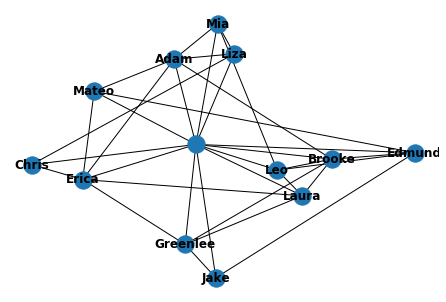

In [272]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [273]:
import seaborn as sns

In [279]:
actor_network.nodes()

NodeView(('Laura', 'Leo', '', 'Greenlee', 'Jake', 'Edmund', 'Mateo', 'Brooke', 'Adam', 'Erica', 'Mia', 'Chris', 'Liza'))

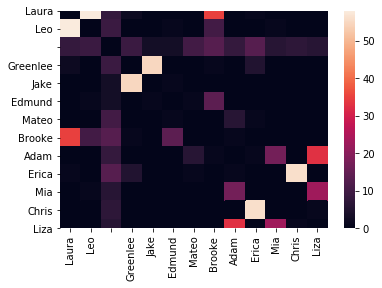

In [288]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        elif (node, node_) not in actor_network.edges():
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
            
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [289]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [290]:
c

[frozenset({'',
            'Adam',
            'Brooke',
            'Chris',
            'Edmund',
            'Erica',
            'Greenlee',
            'Jake',
            'Laura',
            'Leo',
            'Liza',
            'Mateo',
            'Mia'})]

In [291]:
smaller_actor_network = nx.Graph()

In [300]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if (actor_1, actor_2) in actor_network.edges() and actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 30:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


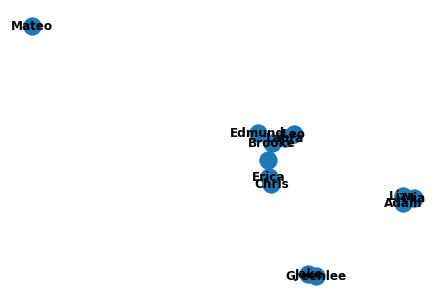

In [301]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

In [302]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [303]:
c

[frozenset({'', 'Brooke', 'Chris', 'Edmund', 'Erica', 'Laura', 'Leo'}),
 frozenset({'Adam', 'Liza', 'Mia'}),
 frozenset({'Greenlee', 'Jake'}),
 frozenset({'Mateo'})]

In [304]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [305]:
dcentralities['Brooke'], dcentralities['Chris']

(0.25, 0.08333333333333333)

In [306]:
import nltk

In [307]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [308]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [309]:
L = []

In [310]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

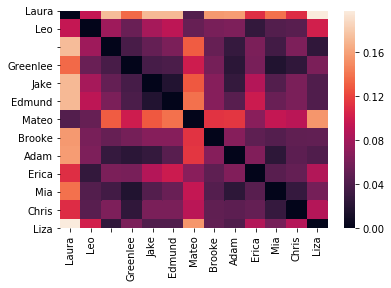

In [311]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

## Comments